# Active Learning Code Example

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import activelearning.querystrategies as qs
from activelearning import ActiveLearningModel

### Create a toy dataset with binary labels

In [2]:
X, y = make_classification(n_features=20, n_samples=500, n_classes=2, flip_y=0.08, random_state=50)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=20, random_state=50)

### Train a classifier on the training data and compute its accuracy on the test data

In [3]:
clf = LinearSVC()
clf.fit(train_X, train_y)
print("Accuracy: {0:.3f}".format(clf.score(test_X, test_y)))

Accuracy: 0.900


### Run the active learning models
We'll compare simple margin and density sampling to the random sampling baseline. 

In [4]:
random_qs = qs.Random()
# ActiveLearningModel will clone clf using sklearn.base.clone, so there is no need to reinstantiate it.
random_al = ActiveLearningModel(clf, random_qs,
                                U_proportion=0.98, random_state=50)
random_scores, _ = random_al.run(train_X, test_X, train_y, test_y)

In [5]:
simple_margin_qs = qs.SimpleMargin()
simple_margin_al = ActiveLearningModel(clf, simple_margin_qs,
                                       U_proportion=0.98, random_state=50)
sm_scores, _ = simple_margin_al.run(train_X, test_X, train_y, test_y)

In [6]:
density_qs = qs.Density()
density_al = ActiveLearningModel(clf, density_qs,
                                       U_proportion=0.98, random_state=50)
density_scores, _ = density_al.run(train_X, test_X, train_y, test_y)

### Plot the learning curves

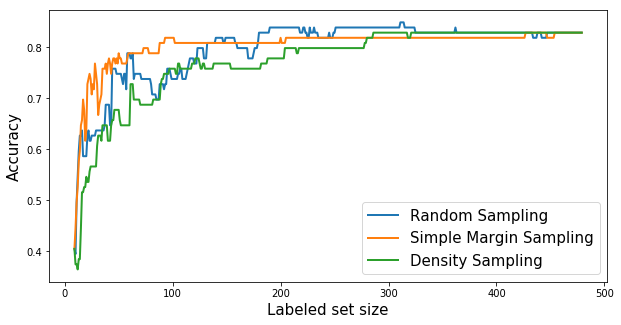

In [7]:
plt.figure(figsize=(10,5))

L_init = train_X.shape[0] - random_scores.shape[0]
L_end = train_X.shape[0]
draws = np.arange(L_init, L_end)
plt.plot(draws, random_scores, label="Random Sampling", linewidth=2)
plt.plot(draws, sm_scores, label="Simple Margin Sampling", linewidth=2)
plt.plot(draws, density_scores, label="Density Sampling", linewidth=2)
plt.legend(loc="lower right", prop={"size": 15})
plt.xlabel("Labeled set size", fontsize=15)
plt.ylabel("Accuracy", fontsize=15)
plt.show()

### Compute normalized ALC

In [8]:
def alc(scores):
    rand_auc = np.repeat(0.5, len(scores))
    A_rand = np.trapz(rand_auc, dx=1.0)
    max_auc = np.repeat(1.0, len(scores))
    A_max = np.trapz(max_auc, dx=1.0)
    alc = np.trapz(scores, dx=1.0)
    norm_alc = (alc - A_rand) / (A_max - A_rand)
    return norm_alc

In [9]:
print("ALCs")
print("Random: {0:.3f}".format(alc(random_scores)))
print("Simple Margin: {0:.3f}".format(alc(sm_scores)))
print("Density: {0:.3f}".format(alc(density_scores)))

ALCs
Random: 0.595
Simple Margin: 0.608
Density: 0.545
